## DeepONet: Learning diffusivity (m) to solution (u) map for the Poisson problem

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. 

## On data
The Dropbox folder [NeuralOperator_Survey_Shared_Data_March2025](https://www.dropbox.com/scl/fo/5dg02otewg7j0bt7rhkuf/AOfAAc2SaWOgO-Yg25IlTXs?rlkey=t900geej8y8z327y5f8wu4yc9&st=t9c8qimk&dl=0) contains the key data to reproduce the results in the survey paper. 

If you did not generate data by running `survey_work/problems/poisson/Poisson.ipynb`, consider copying the contents of dropbox folder `NeuralOperator_Survey_Shared_Data_March2025/survey_work/problems/poisson/data/` into `survey_work/problems/poisson/data/` before running this notebook.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results/neural_operator_prediction_comparison.png" width="800"> </p>

In [ ]:
import sys
import os

import torch
import numpy as np

src_path = "../../src/"
sys.path.append(src_path + 'plotting/') 
from field_plot import field_plot # pyright: ignore[reportMissingImports]
from plot_loss import plot_loss # pyright: ignore[reportMissingImports]

sys.path.append(src_path + 'data/')
from dataMethods import DataProcessor

sys.path.append(src_path + 'nn/deeponet/')
sys.path.append(src_path + 'nn/mlp/') # need this here so that DeepONet can be imported (it imports MLP)
from torch_deeponet import DeepONet 
import uq 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
data_folder = '../../../autodl-tmp/data/'
results_dir = data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [ ]:
num_train = 3500
num_test = 1000

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_Y_components = 1 # scalar field
num_tr_outputs = 100 # number of outputs from the trunk network before they are multiplied
num_br_outputs = 100 # number of outputs from the branch and trunk networks before they are multiplied
out_coordinate_dimension = 2 # domain for output function is 2D


# training hyperparameters
batch_size = 20
epochs = 1000
lr = 1.0e-3
act_fn = torch.relu

data_prefix = 'Poisson'

data = DataProcessor(data_folder + data_prefix + '_samples_.npz', num_train, num_test, num_inp_fn_points, num_out_fn_points, num_Y_components)
train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

X_train: (3500, 2601)
Y_train: (3500, 2601)
X_test: (1000, 2601)
Y_test: (1000, 2601)
X_trunk: (2601, 2)


In [ ]:
num_test_shift = 400
# Shifting data sets
data_type=[['no-ood',0.005,0.2,1,0],['ood-1',0.005,0.2,1,0.03],['ood-2',0.005,0.2,1,0.06],\
           ['ood-3',0.005,0.2,1,0.1],['ood-4',0.005,0.2,1,0.15],['ood-5',0.005,0.2,1,0.2], \
            ['ood-6',0.005,0.2,1,-0.2]]
data_shifting = []
data_shifting_data = []
for datatype in data_type:
    data_shifting.append(DataProcessor(data_folder + data_prefix + f'_samples_{datatype[0]}.npz', 100, 400, num_inp_fn_points, num_out_fn_points, num_Y_components))
    data_shifting_data.append({'X_train': data_shifting[-1].X_test, 'X_trunk': data_shifting[-1].X_trunk, 'Y_train': data_shifting[-1].Y_test})

## Create model and train the network

Using device: cuda
Number of trainable parameters: 179721
--------------------------------------------------
Starting training with 179721 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 4.785e-01, Test Loss (l2 squared): 2.196e-01, Time (sec): 0.464
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 2.723e-02, Test Loss (l2 squared): 2.576e-02, Time (sec): 0.258
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 1.942e-02, Test Loss (l2 squared): 2.135e-02, Time (sec): 0.324
--------------------------------------------------
---------------------------------

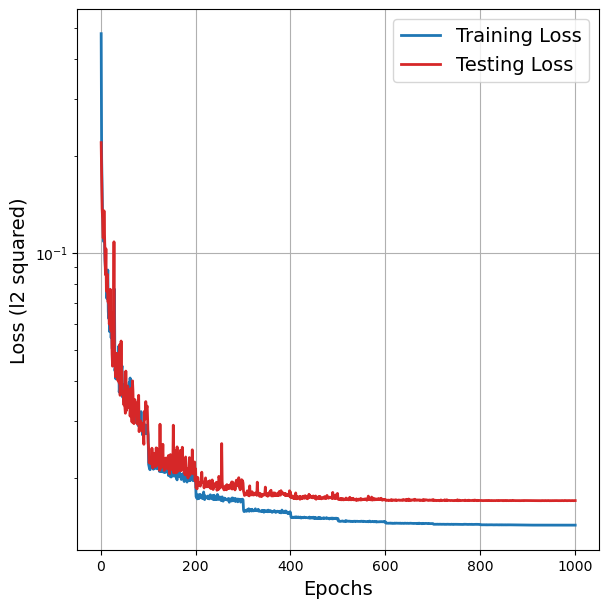

Using device: cuda
Number of trainable parameters: 188041
--------------------------------------------------
Starting training with 188041 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 3.898e-01, Test Loss (l2 squared): 2.470e-01, Time (sec): 0.276
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 2.380e-02, Test Loss (l2 squared): 3.642e-02, Time (sec): 0.456
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 1.615e-02, Test Loss (l2 squared): 1.667e-02, Time (sec): 0.244
--------------------------------------------------
---------------------------------

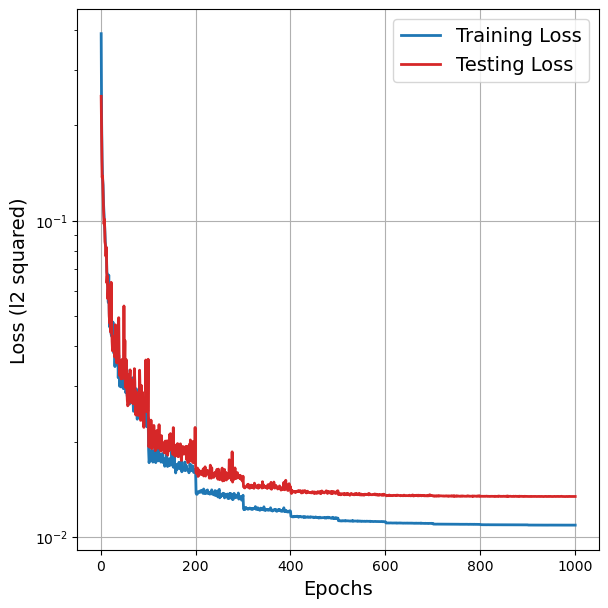

Using device: cuda
Number of trainable parameters: 196361
--------------------------------------------------
Starting training with 196361 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 4.566e-01, Test Loss (l2 squared): 2.757e-01, Time (sec): 0.588
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 2.369e-02, Test Loss (l2 squared): 2.654e-02, Time (sec): 0.440
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 1.666e-02, Test Loss (l2 squared): 1.912e-02, Time (sec): 0.463
--------------------------------------------------
---------------------------------

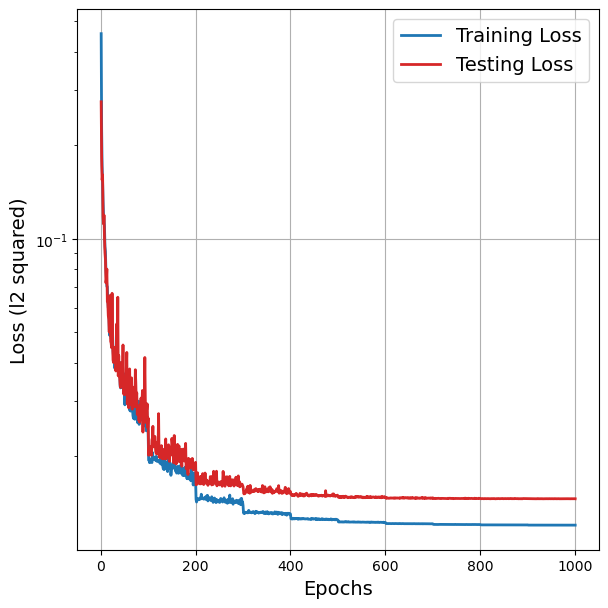

Using device: cuda
Number of trainable parameters: 392265
--------------------------------------------------
Starting training with 392265 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 4.249e-01, Test Loss (l2 squared): 2.783e-01, Time (sec): 0.481
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 2.039e-02, Test Loss (l2 squared): 1.985e-02, Time (sec): 0.495
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 1.441e-02, Test Loss (l2 squared): 1.446e-02, Time (sec): 0.401
--------------------------------------------------
---------------------------------

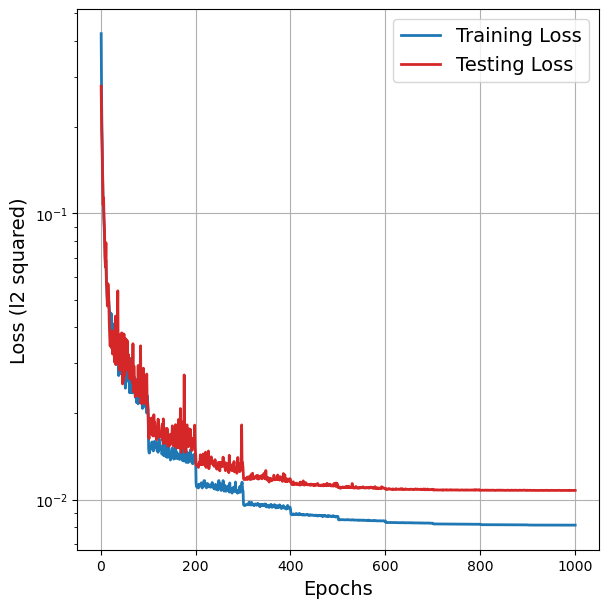

In [ ]:
model_settings = [{'num_layers': 3, 'num_neurons': 64},
                  {'num_layers': 3, 'num_neurons': 128},
                  {'num_layers': 4, 'num_neurons': 64},
                  {'num_layers': 4, 'num_neurons': 128}
                  ]
model_save_files = []
for i, model_setting in enumerate(model_settings):
    num_layers = model_setting['num_layers']
    num_neurons = model_setting['num_neurons']
    model_save_path = results_dir + 'DeepONet_mul/'
    model_save_file = model_save_path + f'model_{i}.pkl'
    model_save_files.append(model_save_file)
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

    model = DeepONet(num_layers, num_neurons, act_fn, num_br_outputs, \
                    num_tr_outputs, num_inp_fn_points, \
                    out_coordinate_dimension, num_Y_components,\
                    save_file = model_save_file)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Number of trainable parameters: {}'.format(trainable_params))
    # save the data and info
    data_to_save = data.get_data_to_save()
    model_metadata = {  'data': data_to_save, \
                        'num_train': num_train, \
                        'num_test': num_test, \
                        'num_inp_fn_points': num_inp_fn_points, \
                        'num_out_fn_points': num_out_fn_points, \
                        'num_Y_components': num_Y_components, \
                        'num_tr_outputs': num_tr_outputs, \
                        'num_br_outputs': num_br_outputs, \
                        'out_coordinate_dimension': out_coordinate_dimension, \
                        'num_layers': num_layers, \
                        'num_neurons': num_neurons, \
                        'epochs': epochs, \
                        'batch_size': batch_size, \
                        'lr': lr}
    # attach it to the model
    model.metadata = model_metadata # pyright: ignore[reportAttributeAccessIssue]
    # Train
    model.train(train_data, test_data, batch_size=batch_size, \
                epochs = epochs, lr = lr, \
                save_model = True, save_epoch = 100)
    plot_loss(model.train_loss_log[:, 0],
              model.test_loss_log[:, 0],
              fs=14, lw=2,
              savefile=results_dir+'loss_his.png',
              figsize=[6, 6])

## Test and plot the output of network

In [5]:
# load the model
models = []
for i, model_save_file in enumerate(model_save_files):
    models.append(torch.load(model_save_file, weights_only=False))
for i, model in enumerate(models):
    Y_test = test_data['Y_train']
    Y_test_pred = model.predict(test_data['X_train'], test_data['X_trunk']).detach().cpu().numpy()
    print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))
    error = np.linalg.norm(Y_test - Y_test_pred, axis = 1)/np.linalg.norm(Y_test, axis = 1)
    print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

def apply_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids] = bc_value
    return u



test_out shape: (1000, 2601), test_pred shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 1.597e-01, Std Loss (rel l2): 5.551e-02
test_out shape: (1000, 2601), test_pred shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 1.429e-01, Std Loss (rel l2): 5.035e-02
test_out shape: (1000, 2601), test_pred shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 1.500e-01, Std Loss (rel l2): 5.512e-02
test_out shape: (1000, 2601), test_pred shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 1.272e-01, Std Loss (rel l2): 4.465e-02


## Uncertainty Quantification Sampling

## HMC

In [ ]:
hmc_samples = []
for i, model_save_file in enumerate(model_save_files):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)

    # Use a subset of test data for HMC (full dataet may be too slow)
    num_hmc_samples_data = 1000  # number of data points to use
    hmc_indices = np.random.choice(num_test, num_hmc_samples_data, replace=False)

    x_branch_hmc = test_data['X_train'][hmc_indices]
    x_trunk_hmc = test_data['X_trunk']
    y_hmc = test_data['Y_train'][hmc_indices]

    print(f"Using {num_hmc_samples_data} test samples for HMC")
    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

    # Initialize from current model parameters
    flat0 = uq.pack_params(model).to(device)
    print(f"Initial parameter vector shape: {flat0.shape}")

    # Create log probability function
    log_prob = uq.make_log_prob_fn(model, x_branch_hmc, x_trunk_hmc, y_hmc, 
                                noise_std=0.05, prior_std=1.0)

    # Adaptive HMC settings
    hmc_num_samples = 1000
    hmc_burn_in = 100          # Increased burn-in for adaptation
    hmc_adapt_steps = 50       # Steps to adapt step size
    hmc_initial_step_size = 1e-7
    hmc_leapfrog_steps = 20
    hmc_target_accept = 0.75    # Target acceptance rate (65-80% is optimal)

    print(f"\nAdaptive HMC Settings:")
    print(f"  num_samples: {hmc_num_samples}")
    print(f"  burn_in: {hmc_burn_in}")
    print(f"  adapt_steps: {hmc_adapt_steps}")
    print(f"  initial_step_size: {hmc_initial_step_size}")
    print(f"  leapfrog_steps: {hmc_leapfrog_steps}")
    print(f"  target_accept: {hmc_target_accept}")
    print()

    hmcsamples, acc_rate, final_step_size, step_size_history = uq.hmc_adaptive(
        log_prob, 
        flat0.requires_grad_(True), 
        target_accept=hmc_target_accept,
        initial_step_size=hmc_initial_step_size, 
        leapfrog_steps=hmc_leapfrog_steps, 
        num_samples=hmc_num_samples, 
        burn_in=hmc_burn_in,
        adapt_steps=hmc_adapt_steps
    )
    hmc_samples.append(hmcsamples)
    print(f"\n{'='*60}")
    print(f"Final Results:")
    print(f"  Acceptance rate: {acc_rate:.3f} ({acc_rate*100:.1f}%)")
    print(f"  Final step size: {final_step_size:.2e}")
    print(f"  Collected {len(hmcsamples)} samples")
    print(f"{'='*60}")
hmc_samples = torch.stack(hmc_samples)
torch.save(hmc_samples, model_save_path + 'hmc_samples_mul.pkl')


In [ ]:
results_id = []
results_shifting = []
std_id = []
std_shifting = []
# load the samples if needed.
# hmc_samples = torch.load(model_save_path + 'hmc_samples_mul.pt').to(device)

In [ ]:
for i in range(4):
    std_hmc = []
    results_hmc = []
    for j in range(-1,7):
        model = torch.load(model_save_file, weights_only=False)
        model.to(device)
        if j==-1:
            std, result = uq.uqevaluation(num_test_shift, test_data, model, 'hmc', hmc_samples=hmc_samples[i].clone())  # pyright: ignore[reportAttributeAccessIssue]
            std_id.append(std)
            results_id.append(result)
        else:
            std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'hmc', hmc_samples=hmc_samples[i].clone())  # pyright: ignore[reportAttributeAccessIssue]
            std_hmc.append(std_i)
            results_hmc.append(result_i)
        print(f" Complete {j+2} epoch")
    std_shifting.append(np.stack(std_hmc))
    results_shifting.append(np.stack(results_hmc))
# Save UQ results
results_id = np.array(results_id) # modeltype*metric
results_shifting = np.array(results_shifting) # modeltype*datatype*metric
std_id = np.array(std_id) # modeltype*sample
std_shifting = np.array(std_shifting) # modeltype*datatype*sample
np.savez(model_save_path + 'uq_results_deeponet_mul.npz', results_id=results_id, results_shifting=results_shifting, std_id=std_id, std_shifting=std_shifting)

## Assess evaluation metrics

In [ ]:
# load data if needed
results_id, results_shifting, std_id, std_shifting = np.load(model_save_path + 'uq_results_deeponet_mul.npz').values()

### ID data performance

In [ ]:
uq.comparison_uq(*results_id)

### Shifting data performance

In [ ]:
method = ['3x64', '3x128', '4x64', '4x128']
levels = [0, 0.03, 0.06, 0.1, 0.15, 0.2]
results = np.concatenate((results_id, results_shifting[1:]), axis=0)
uq.run_regression_shift(method, levels, results)

### Robustness check

In [ ]:
uq.comparison_uq(*results_shifting[:,0,:])